<a href="https://colab.research.google.com/github/JVR27XD/SAM/blob/main/fine-tuning/fine_tuning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Montar Google Drive y definir rutas
from google.colab import drive
drive.mount('/content/drive')

RUTA_PROYECTO = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI"
LABELED_DIR = f"{RUTA_PROYECTO}/Labeled"
CHECKPOINTS_DIR = f"{RUTA_PROYECTO}/checkpoints"

import os
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
# 📦 2. Clonar Segment Anything Model (SAM) y descargar pesos ViT-B
import os, urllib.request

# 1) Clonar el repo solo si no existe
if not os.path.isdir("/content/segment-anything"):
    !git clone -q https://github.com/facebookresearch/segment-anything.git /content/segment-anything
%cd /content/segment-anything



# 2) Usar el CHECKPOINTS_DIR
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

checkpoint_path = os.path.join(CHECKPOINTS_DIR, "sam_vit_b.pth")
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

if not os.path.exists(checkpoint_path):
    print("⬇️ Descargando SAM ViT-B (sam_vit_b.pth)…")
    urllib.request.urlretrieve(url, checkpoint_path)
    print(f"✅ Guardado en: {checkpoint_path}")
else:
    print(f"✅ Checkpoint ya existe en: {checkpoint_path}")


/content/segment-anything
✅ Checkpoint ya existe en: /content/checkpoints/sam_vit_b.pth


In [ ]:
# Cargar modelo SAM (ViT-B) con comprobaciones y reproducibilidad
import os
import torch
from segment_anything import sam_model_registry

# Reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Asegura que el checkpoint existe
assert os.path.exists(checkpoint_path), f"No se encontró el checkpoint: {checkpoint_path}"

# Instancia el modelo y carga pesos
sam = sam_model_registry['vit_b'](checkpoint=checkpoint_path)

# Mover a dispositivo y activar modo entrenamiento
sam.to(device=DEVICE)
sam.train()

print(f"✅ SAM ViT-B cargado en {DEVICE}. Parámetros totales: {sum(p.numel() for p in sam.parameters()):,}")


✅ SAM ViT-B cargado en cuda. Parámetros totales: 93,735,472


In [ ]:
# Función robusta para generar máscaras desde JSON (LabelMe)
import json
import numpy as np
from PIL import Image, ImageDraw

def mask_from_json(
    json_path,
    original_size,                # (W_img, H_img) de la imagen real (por si el JSON no lo trae)
    target_size=(1024, 1024),     # (W_tgt, H_tgt) -> OJO: PIL usa (width, height)
    return_bool=False             # si True, devuelve np.uint8 en {0,1}; si False, PIL "L" 0/255
):
    """
    Convierte anotaciones LabelMe a una máscara binaria en 'target_size'.
    - Soporta shape_type: 'polygon', 'rectangle', 'polyline', 'linestrip'
    - Escala puntos desde el espacio de anotación (imageWidth/Height del JSON si existen,
      si no, usa original_size) a (target_width, target_height).
    - Dibuja con relleno 255 (fondo 0). Opcionalmente devuelve binaria 0/1.
    """

    # --- Cargar JSON ---
    with open(json_path, "r") as f:
        data = json.load(f)

    # --- Dimensiones de referencia de la anotación ---
    # Preferimos las del JSON si existen; si no, usamos las reales que nos pasas
    ann_w = int(data.get("imageWidth",  original_size[0]))
    ann_h = int(data.get("imageHeight", original_size[1]))

    # --- Destino (PIL usa (width, height)) ---
    tgt_w, tgt_h = int(target_size[0]), int(target_size[1])
    sx = tgt_w / float(ann_w)
    sy = tgt_h / float(ann_h)

    # --- Lienzo vacío ---
    mask = Image.new("L", (tgt_w, tgt_h), 0)
    draw = ImageDraw.Draw(mask)

    # --- Helper: escalar + clamp + a enteros ---
    def _scale_and_clamp(points):
        out = []
        for x, y in points:
            xi = int(round(max(0, min(tgt_w - 1, x * sx))))
            yi = int(round(max(0, min(tgt_h - 1, y * sy))))
            out.append((xi, yi))
        return out

    # --- Recorrer shapes ---
    for shape in data.get("shapes", []):
        pts = shape.get("points", [])
        if not pts:
            continue

        st = shape.get("shape_type", "polygon").lower()

        # Rectángulo -> 4 esquinas
        if st == "rectangle" and len(pts) == 2:
            (x0, y0), (x1, y1) = pts
            pts = [(x0, y0), (x1, y0), (x1, y1), (x0, y1)]

        # Polilínea/linestrip: si hay >=3 puntos, cerramos la forma
        if st in ("polyline", "linestrip") and len(pts) >= 3:
            pts = pts + [pts[0]]  # cerrar

        # Escalar y recortar a (tgt_w, tgt_h)
        pts_scaled = _scale_and_clamp(pts)

        # Para rellenar un polígono necesitamos mínimo 3 vértices distintos
        if len(pts_scaled) >= 3:
            # Relleno con 255 (más compatible con umbralización > 127)
            draw.polygon(pts_scaled, outline=255, fill=255)

    if return_bool:
        # Devuelve binaria 0/1 (np.uint8)
        return (np.array(mask, dtype=np.uint8) > 127).astype(np.uint8)

    # Por defecto, devolvemos PIL "L" con 0/255
    return mask


In [ ]:
import os
import glob
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, InterpolationMode as IM
import torchvision.transforms.functional as TF
from PIL import Image


def _find_images(img_dir, exts=(".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")):
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(img_dir, "**", f"*{ext}"), recursive=True))
    return sorted(paths)

class PCBDefectDatasetFixed(Dataset):
    def __init__(self, img_dir, json_dir, size=(1024, 1024)):
        self.img_paths = _find_images(img_dir)
        # conserva solo las que tienen su JSON correspondiente
        self.img_paths = [
            p for p in self.img_paths
            if os.path.exists(os.path.join(json_dir, os.path.splitext(os.path.basename(p))[0] + ".json"))
        ]
        self.json_dir = json_dir
        # PIL y TF usan (width, height).
        self.size = (int(size[0]), int(size[1]))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        base = os.path.splitext(os.path.basename(img_path))[0]
        json_path = os.path.join(self.json_dir, base + ".json")

        # --- Imagen original ---
        image = Image.open(img_path).convert("RGB")
        W, H = image.size  # (width, height) en píxeles

        # --- Máscara desde JSON, alineada y ya en self.size ---
        # return_bool=True => np.uint8 en {0,1}; internamente maneja polygon/rectangle/polyline/linestrip
        m_bin = mask_from_json(
            json_path=json_path,
            original_size=(W, H),
            target_size=self.size,
            return_bool=True
        )  # (H_tgt, W_tgt) en {0,1}

        # --- Redimensionar la imagen a self.size con bilinear ---
        image_rs = TF.resize(image, self.size, interpolation=IM.BILINEAR)

        # --- Tensores de salida ---
        image_t = ToTensor()(image_rs)                 # float32, [0,1], shape (3, H_tgt, W_tgt)
        mask_t  = torch.from_numpy(m_bin).float()      # float32, {0,1}, shape (H_tgt, W_tgt)
        mask_t  = mask_t.unsqueeze(0)                  # (1, H_tgt, W_tgt)

        return image_t, mask_t


In [ ]:
IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Dataset"
JSON_DIR = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"

dataset = PCBDefectDatasetFixed(IMG_DIR, JSON_DIR, size=(1024, 1024))
n = len(dataset)
print(f"Total ejemplos: {n}")
assert n > 0, f"No se encontraron pares imagen+JSON en:\n  IMG_DIR={IMG_DIR}\n  JSON_DIR={JSON_DIR}"

# Muestra el primero con comprobaciones mínimas
img, mask = dataset[0]
print("Image shape:", img.shape, " | rango:", (float(img.min()), float(img.max())))
print("Mask shape:", mask.shape, " | valores únicos:", torch.unique(mask))

# Comprobaciones
assert 0.0 - 1e-6 <= img.min() and img.max() <= 1.0 + 1e-6, "Imagen fuera de [0,1]"
u = torch.unique(mask)
assert set([float(v) for v in u]) <= {0.0, 1.0}, f"Máscara no binaria: valores={u.tolist()}"


Total ejemplos: 428
Image shape: torch.Size([3, 1024, 1024])  | rango: (0.0, 1.0)
Mask shape: torch.Size([1, 1024, 1024])  | valores únicos: tensor([0., 1.])


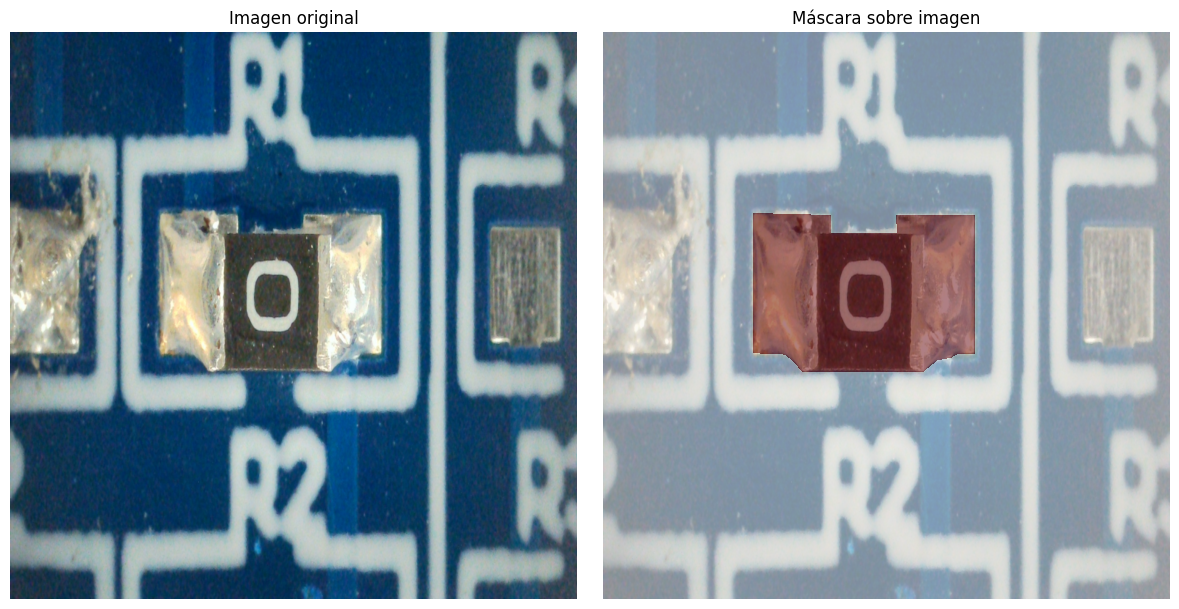

In [ ]:
import matplotlib.pyplot as plt
import torch

def mostrar_ejemplo(dataset, idx=0):
    # Guardas básicas
    n = len(dataset)
    assert 0 <= idx < n, f"idx fuera de rango (0..{n-1}), recibido: {idx}"

    img, mask = dataset[idx]  # img: [3,H,W] float, mask: [1,H,W] 0/1

    # Convertir a numpy en CPU
    img_np  = img.permute(1, 2, 0).detach().cpu().numpy()
    mask_np = mask.squeeze(0).detach().cpu().numpy()

    # Asegurar rango imagen [0,1] por si acaso
    img_np = img_np.clip(0.0, 1.0)

    plt.figure(figsize=(12, 6))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Imagen original")
    plt.axis("off")

    # Imagen con máscara superpuesta
    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    # Evita suavizado de bordes y mapea 0/1 correctamente
    plt.imshow(mask_np, alpha=0.5, cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
    plt.title("Máscara sobre imagen")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualizar uno
mostrar_ejemplo(dataset, idx=0)


In [ ]:
import os, time, math, json
from datetime import timedelta
import torch
import pandas as pd
from torch.nn.functional import interpolate
from typing import Optional, Callable
import matplotlib.pyplot as plt

def _fmt_eta(seconds: float) -> str:
    return str(timedelta(seconds=int(max(0, seconds))))

import os, time, math, json
from datetime import timedelta
import torch
import pandas as pd
from torch.nn.functional import interpolate
from typing import Optional, Callable
import matplotlib.pyplot as plt

def _fmt_eta(seconds: float) -> str:
    return str(timedelta(seconds=int(max(0, seconds))))

def train_sam_decoder(
    sam,
    train_loader,
    epochs: int = 20,
    lr: float = 1e-4,
    device: str = "cuda",
    save_dir: str = "/content/drive/MyDrive/TFG",
    val_loader: Optional[torch.utils.data.DataLoader] = None,
    eval_fn: Optional[Callable] = None,   # debe devolver dict con keys: IoU, Dice, Prec, Rec
    best_by: str = "dice",                # "dice" o "iou"
    save_every: int = 1,
    use_amp: bool = True,
    grad_clip: Optional[float] = 1.0,
    plot_end: bool = True,
):
    assert hasattr(sam, "mask_decoder"), "El modelo SAM no tiene 'mask_decoder'."
    assert isinstance(epochs, int) and epochs > 0
    assert isinstance(lr, float) and lr > 0
    assert len(train_loader) > 0, "train_loader está vacío."
    os.makedirs(save_dir, exist_ok=True)

    # 🔧 Normalización oficial de SAM (en espacio [0,1])
    IMAGE_MEAN = torch.tensor([123.675, 116.28, 103.53]) / 255.0
    IMAGE_STD  = torch.tensor([58.395, 57.12, 57.375]) / 255.0
    IMAGE_MEAN = IMAGE_MEAN.view(1,3,1,1).to(device)
    IMAGE_STD  = IMAGE_STD.view(1,3,1,1).to(device)

    # Congelar todo salvo decoder
    for p in sam.parameters():
        p.requires_grad = False
    for p in sam.mask_decoder.parameters():
        p.requires_grad = True
    assert any(p.requires_grad for p in sam.mask_decoder.parameters())
    assert not any(p.requires_grad for n,p in sam.named_parameters() if "mask_decoder" not in n)

    sam.to(device)
    sam.train()

    optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    scaler = torch.amp.GradScaler("cuda", enabled=(use_amp and device.startswith("cuda")))
    metrics_log, best_metric, best_path = [], -math.inf, None

    total_batches = epochs * len(train_loader)
    global_start = time.time()

    print("==> Entrenando decoder de SAM")
    for epoch in range(epochs):
        epoch_start = time.time()
        total_loss = 0.0
        num_updates = 0
        did_sanity_check = False

        # acumuladores de métricas de train (promedio por época)
        tr_inter = tr_union = tr_ps = tr_gs = 0.0

        for i, (images, masks_gt) in enumerate(train_loader):
            images = images.to(device, non_blocking=True)   # (B,3,H,W)
            masks_gt = masks_gt.to(device, non_blocking=True)  # (B,1,H,W)

            B, C, H, W = images.shape
            assert B >= 1 and C == 3, f"Imagen con shape inesperado: {images.shape}"
            assert masks_gt.shape == (B, 1, H, W), f"Máscara no alinea: {masks_gt.shape} vs {(B,1,H,W)}"

            if not did_sanity_check:
                mn, mx = images.min().item(), images.max().item()
                assert mn >= -1e-3 and mx <= 1.0 + 1e-3, f"Rango imagen [{mn:.3f},{mx:.3f}] (se espera [0,1])"
                uniq = torch.unique(masks_gt)
                assert torch.all((uniq <= 1.0+1e-6) & (uniq >= -1e-6)), f"Máscara fuera de [0,1], valores: {uniq}"
                did_sanity_check = True

            for b in range(B):
                image = images[b].unsqueeze(0)   # (1,3,1024,1024) en [0,1]
                mask_gt = masks_gt[b]            # (1,1024,1024)

                # Punto positivo (centroide)
                coords = torch.nonzero(mask_gt[0] > 0.5, as_tuple=False)
                if len(coords) == 0:
                    continue
                point = coords.float().mean(dim=0)   # (y,x)

                with torch.amp.autocast("cuda", enabled=(use_amp and device.startswith("cuda"))):
                    # ✅ Normalización SAM
                    image_input = (image - IMAGE_MEAN) / IMAGE_STD  # (1,3,1024,1024)

                    with torch.no_grad():
                        image_embedding = sam.image_encoder(image_input)

                    # Punto en resolución 1024
                    point_coords = point.flip(0).view(1,1,2).to(dtype=torch.float32, device=device)  # (x,y)
                    point_labels = torch.tensor([[1]], dtype=torch.int64, device=device)

                    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                        points=(point_coords, point_labels), boxes=None, masks=None
                    )

                    low_res_logits, _ = sam.mask_decoder(
                        image_embeddings=image_embedding,
                        image_pe=sam.prompt_encoder.get_dense_pe(),
                        sparse_prompt_embeddings=sparse_embeddings,
                        dense_prompt_embeddings=dense_embeddings,
                        multimask_output=False,
                    )

                    # A tamaño GT
                    logits_up = interpolate(low_res_logits, size=mask_gt.shape[-2:], mode="bilinear", align_corners=False)
                    loss = criterion(logits_up, mask_gt.unsqueeze(0))

                if not torch.isfinite(loss):
                    raise RuntimeError(f"Loss no finita en epoch {epoch+1}, batch {i}, sample {b}: {loss.item()}")

                optimizer.zero_grad(set_to_none=True)
                if scaler.is_enabled():
                    scaler.scale(loss).backward()
                    if grad_clip is not None:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(sam.mask_decoder.parameters(), grad_clip)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    if grad_clip is not None:
                        torch.nn.utils.clip_grad_norm_(sam.mask_decoder.parameters(), grad_clip)
                    optimizer.step()

                total_loss += loss.item()
                num_updates += 1

                # Métricas de train
                with torch.no_grad():
                    prob = torch.sigmoid(logits_up)
                    pred_bin = (prob > 0.5).float()
                    gt_bin   = (mask_gt.unsqueeze(0) > 0.5).float()
                    tr_inter += (pred_bin * gt_bin).sum().item()
                    tr_union += (pred_bin + gt_bin).clamp(0,1).sum().item()
                    tr_ps    += pred_bin.sum().item()
                    tr_gs    += gt_bin.sum().item()

            # ETA por batch
            elapsed_epoch = time.time() - epoch_start
            batches_done  = epoch * len(train_loader) + (i + 1)
            batches_left  = total_batches - batches_done
            mean_batch_s  = (time.time() - global_start) / max(1, batches_done)
            eta_total     = mean_batch_s * batches_left
            eta_epoch     = (elapsed_epoch / (i + 1)) * (len(train_loader) - (i + 1))

            if i % 10 == 0:
                last_loss = float(loss.item()) if 'loss' in locals() else float('nan')
                print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(train_loader)}] "
                      f"Loss: {last_loss:.4f} | ETA(época): {_fmt_eta(eta_epoch)} | ETA(total): {_fmt_eta(eta_total)}")

        # ---- Promedio de train por época
        avg_loss = total_loss / max(1, num_updates)
        iou_tr   = tr_inter / (tr_union + 1e-7)
        dice_tr  = 2 * tr_inter / (tr_ps + tr_gs + 1e-7)
        prec_tr  = tr_inter / (tr_ps + 1e-7)
        rec_tr   = tr_inter / (tr_gs + 1e-7)

        row = {"epoch": epoch+1, "loss": avg_loss,
               "train_iou": iou_tr, "train_dice": dice_tr,
               "train_prec": prec_tr, "train_rec": rec_tr}

        # ---- Validación
        ref_value = dice_tr if best_by.lower()=="dice" else iou_tr
        if val_loader is not None and eval_fn is not None:
            sam.eval()
            with torch.no_grad():
                val_metrics = eval_fn(sam, val_loader, device=device, label=f"fine-tuned @ epoch {epoch+1}")
            sam.train()
            row.update({"val_iou": val_metrics["IoU"], "val_dice": val_metrics["Dice"],
                        "val_prec": val_metrics["Prec"], "val_rec": val_metrics["Rec"]})
            ref_value = val_metrics["Dice"] if best_by.lower()=="dice" else val_metrics["IoU"]

        # ---- Print por epoch
        msg = (f"✅ Epoch {epoch+1}/{epochs} | Loss:{avg_loss:.4f} | "
               f"Train IoU:{iou_tr:.4f} Dice:{dice_tr:.4f} Prec:{prec_tr:.4f} Rec:{rec_tr:.4f}")
        if "val_iou" in row:
            msg += (f" || VAL IoU:{row['val_iou']:.4f} Dice:{row['val_dice']:.4f} "
                    f"Prec:{row['val_prec']:.4f} Rec:{row['val_rec']:.4f}")
        print(msg)

        # ---- Guardar mejor checkpoint según ref_value
        if ref_value > best_metric:
            best_metric = ref_value
            best_path = os.path.join(save_dir, f"sam_decoder_best_{best_by}.pth")
            torch.save(sam.mask_decoder.state_dict(), best_path)
            print(f"🏅 Nuevo mejor checkpoint ({best_by}={best_metric:.4f}) guardado en: {best_path}")

        metrics_log.append(row)

        # ---- Guardado periódico
        if ((epoch + 1) % max(1, save_every)) == 0:
            path = os.path.join(save_dir, f"sam_decoder_epoch{epoch+1}.pth")
            torch.save(sam.mask_decoder.state_dict(), path)
            print(f"💾 Decoder guardado: {path}")

    # ---- Guardar CSV
    df = pd.DataFrame(metrics_log)
    csv_path = os.path.join(save_dir, "sam_decoder_metrics.csv")
    df.to_csv(csv_path, index=False)
    print(f"📁 Métricas guardadas en '{csv_path}'")
    if best_path:
        print(f"🏁 Mejor checkpoint: {best_path}")

    # ---- Gráficas al final
    if plot_end:
        def plot_metric(ax, df, train_col, val_col=None, title="", ylim=None):
            ax.plot(df["epoch"], df[train_col], marker="o", label="train")
            if val_col is not None and val_col in df.columns:
                ax.plot(df["epoch"], df[val_col], marker="o", linestyle="--", label="val")
            ax.set_title(title); ax.set_xlabel("Epoch")
            if ylim is not None: ax.set_ylim(*ylim)
            ax.grid(True, alpha=0.3); ax.legend()

        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        plot_metric(axes[0,0], df, "loss", title="Loss")
        plot_metric(axes[0,1], df, "train_iou",  val_col="val_iou",  title="IoU",  ylim=(0,1.05))
        plot_metric(axes[0,2], df, "train_dice", val_col="val_dice", title="Dice", ylim=(0,1.05))
        plot_metric(axes[1,0], df, "train_prec", val_col="val_prec", title="Precisión", ylim=(0,1.05))
        plot_metric(axes[1,1], df, "train_rec",  val_col="val_rec",  title="Recall",    ylim=(0,1.05))
        axes[1,2].axis("off")
        plt.tight_layout()
        fig_path = os.path.join(save_dir, "sam_decoder_training_curves.png")
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"🖼️ Curvas guardadas en: {fig_path}")

    return df



In [ ]:
from torch.utils.data import DataLoader, random_split

IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Dataset"
JSON_DIR = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"

# dataset personalizado
dataset_fixed = PCBDefectDatasetFixed(IMG_DIR, JSON_DIR, size=(1024, 1024))

# dividir train/val (80/20) con semilla fija
N = len(dataset_fixed)
val_ratio = 0.2
n_val = int(round(N * val_ratio))
n_train = N - n_val

train_dataset, val_dataset = random_split(
    dataset_fixed, [n_train, n_val], generator=torch.Generator().manual_seed(42)
)

# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2,
    pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=2,
    pin_memory=True, persistent_workers=True
)

print(f"Total: {N} | Train: {len(train_dataset)} | Val: {len(val_dataset)}")


Total: 428 | Train: 342 | Val: 86


In [ ]:
# Evaluación SAM con preprocesado oficial (ResizeLongestSide + normalización SAM + padding)
import numpy as np
import torch
from torch.nn.functional import interpolate, pad
from segment_anything.utils.transforms import ResizeLongestSide

# Constantes de normalización de SAM en espacio [0,1]
_IMAGE_MEAN = torch.tensor([123.675, 116.28, 103.53]) / 255.0
_IMAGE_STD  = torch.tensor([58.395, 57.12, 57.375]) / 255.0

import numpy as np, torch
from segment_anything import SamPredictor
from torch.nn.functional import interpolate

def evaluate_sam_predictor(sam, loader, device="cuda", label="val", thr=0.5):
    """
    Valida con el pipeline oficial de SAM (ResizeLongestSide + padding + normalización).
    Prompt: un punto positivo en el centroide de la GT (igual que en train).
    """
    sam.eval().to(device)
    predictor = SamPredictor(sam)

    inter = union = ps = gs = 0.0
    with torch.no_grad():
        for images, masks_gt in loader:
            images = images.to(device, non_blocking=True)   # (B,3,H,W) en [0,1]
            masks_gt = masks_gt.to(device, non_blocking=True)  # (B,1,H,W)

            B, _, H, W = images.shape
            for b in range(B):
                img01 = images[b].permute(1,2,0).detach().cpu().numpy()  # H×W×3 en [0,1]
                gt    = (masks_gt[b] > 0.5).float()                      # (1,H,W)

                if gt.sum() == 0:
                    continue

                # Centroide (y,x) -> (x,y) para predictor
                coords = torch.nonzero(gt[0] > 0.5, as_tuple=False).float()
                cy, cx = coords.mean(dim=0)
                point_coords = np.array([[cx.item(), cy.item()]], dtype=np.float32)
                point_labels = np.array([1], dtype=np.int32)

                # Predictor
                img_uint8 = (img01 * 255).astype(np.uint8)
                predictor.set_image(img_uint8)
                masks_pred, _, _ = predictor.predict(
                    point_coords=point_coords,
                    point_labels=point_labels,
                    multimask_output=False
                )

                pred = torch.from_numpy(masks_pred[0]).to(device).float().unsqueeze(0).unsqueeze(0)
                if pred.shape[-2:] != gt.shape[-2:]:
                    pred = interpolate(pred, size=gt.shape[-2:], mode="nearest")

                pred_bin = (pred > thr).float()

                inter += (pred_bin * gt.unsqueeze(0)).sum().item()
                union += (pred_bin + gt.unsqueeze(0)).clamp(0,1).sum().item()
                ps    += pred_bin.sum().item()
                gs    += gt.sum().item()

    iou  = inter / (union + 1e-7)
    dice = 2 * inter / (ps + gs + 1e-7)
    prec = inter / (ps + 1e-7)
    rec  = inter / (gs + 1e-7)
    return {"IoU": iou, "Dice": dice, "Prec": prec, "Rec": rec}


==> Entrenando decoder de SAM
[Epoch 1/20] [Batch 1/86] Loss: 0.0078 | ETA(época): 0:03:42 | ETA(total): 1:15:08
[Epoch 1/20] [Batch 11/86] Loss: 0.0341 | ETA(época): 0:01:26 | ETA(total): 0:32:40
[Epoch 1/20] [Batch 21/86] Loss: 0.0354 | ETA(época): 0:01:10 | ETA(total): 0:30:51
[Epoch 1/20] [Batch 31/86] Loss: 0.0072 | ETA(época): 0:00:58 | ETA(total): 0:30:07
[Epoch 1/20] [Batch 41/86] Loss: 0.0202 | ETA(época): 0:00:46 | ETA(total): 0:29:13
[Epoch 1/20] [Batch 51/86] Loss: 0.0096 | ETA(época): 0:00:36 | ETA(total): 0:28:45
[Epoch 1/20] [Batch 61/86] Loss: 0.0229 | ETA(época): 0:00:25 | ETA(total): 0:28:22
[Epoch 1/20] [Batch 71/86] Loss: 0.0242 | ETA(época): 0:00:15 | ETA(total): 0:28:00
[Epoch 1/20] [Batch 81/86] Loss: 0.0096 | ETA(época): 0:00:05 | ETA(total): 0:27:38
✅ Epoch 1/20 | Loss:0.0177 | Train IoU:0.9201 Dice:0.9584 Prec:0.9515 Rec:0.9653 || VAL IoU:0.9346 Dice:0.9662 Prec:0.9495 Rec:0.9835
🏅 Nuevo mejor checkpoint (dice=0.9662) guardado en: /content/drive/MyDrive/TFG/ch

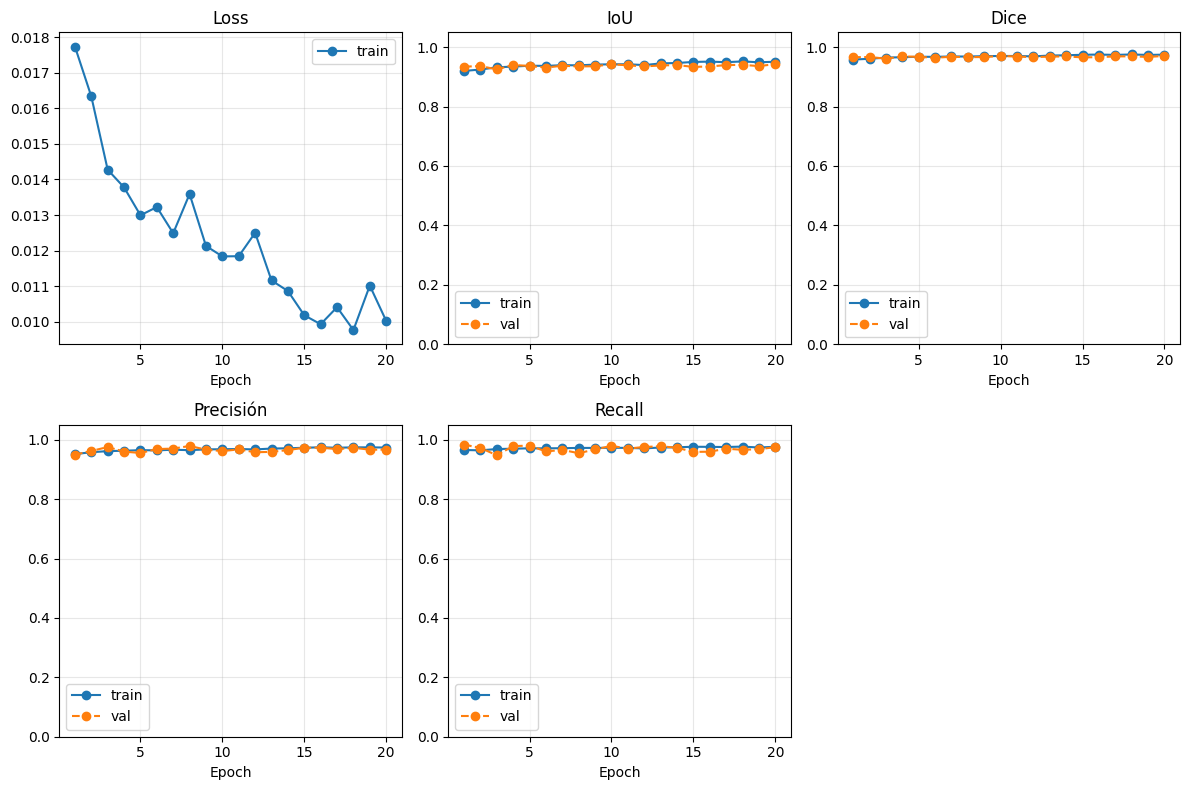

🖼️ Curvas guardadas en: /content/drive/MyDrive/TFG/checkpoints/sam_decoder_training_curves.png


In [ ]:
df_metrics = train_sam_decoder(
    sam,
    train_loader,
    epochs=20,
    lr=1e-4,
    device="cuda",
    save_dir="/content/drive/MyDrive/TFG/checkpoints",
    val_loader=val_loader,
    eval_fn=evaluate_sam_predictor,
    best_by="dice",
    save_every=5,
    use_amp=True,
    grad_clip=1.0,
)

In [ ]:
# ---- imports para la evaluación
import torch
import numpy as np
from tqdm import tqdm
from segment_anything import SamPredictor
from torch.nn.functional import interpolate

def evaluate_sam_pretrained(sam, dataloader, device="cuda", imagenet_norm=False, thr=0.5):
    """
    Evalúa SAM sin fine-tuning usando un point prompt en el centroide de la GT.
    """
    sam.eval().to(device)
    predictor = SamPredictor(sam)

    # Para desnormalizar si procede
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

    iou_list, dice_list, precision_list, recall_list = [], [], [], []

    with torch.no_grad():
        for images, masks_gt in tqdm(dataloader, desc="Evaluando SAM preentrenado"):
            images = images.to(device, non_blocking=True)
            masks_gt = masks_gt.to(device, non_blocking=True)

            # Desnormalizar si procede (tu Dataset -> [0,1], mantener False)
            if imagenet_norm:
                images_rgb01 = (images * std + mean).clamp(0, 1)
            else:
                images_rgb01 = images.clamp(0, 1)

            B, _, H, W = images.shape
            for b in range(B):
                gt = masks_gt[b]  # (1,H,W)

                # Punto positivo (centroide)
                coords = torch.nonzero(gt[0] > 0.5, as_tuple=False)
                if coords.numel() == 0:
                    continue
                cy, cx = coords.float().mean(dim=0)  # (y,x)

                # Imagen RGB uint8 HWC para SamPredictor
                img_np = (images_rgb01[b].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)

                predictor.set_image(img_np)  # RGB
                point_coords = np.array([[cx.item(), cy.item()]], dtype=np.float32)  # (x,y)
                point_labels = np.array([1], dtype=np.int32)

                masks_pred, _, _ = predictor.predict(
                    point_coords=point_coords, point_labels=point_labels, multimask_output=False
                )

                pred = torch.from_numpy(masks_pred[0]).to(device).float().unsqueeze(0).unsqueeze(0)  # (1,1,h,w)
                gt_bin = (gt.unsqueeze(0) > 0.5).float()  # (1,1,H,W)

                if pred.shape[-2:] != gt_bin.shape[-2:]:
                    gt_bin = interpolate(gt_bin, size=pred.shape[-2:], mode="nearest")

                pred_bin = (pred > thr).float()

                inter = (pred_bin * gt_bin).sum().item()
                union = (pred_bin + gt_bin).clamp(0,1).sum().item()
                ps = pred_bin.sum().item()
                gs = gt_bin.sum().item()

                iou  = inter / (union + 1e-7)
                dice = 2 * inter / (ps + gs + 1e-7)
                prec = inter / (ps + 1e-7)
                rec  = inter / (gs + 1e-7)

                iou_list.append(iou); dice_list.append(dice)
                precision_list.append(prec); recall_list.append(rec)

    if not iou_list:
        print("⚠️ No se evaluaron muestras válidas (todas sin máscara positiva).")
        return {"IoU":0.0,"Dice":0.0,"Prec":0.0,"Rec":0.0,"Images":0}

    res = {
        "IoU": float(np.mean(iou_list)),
        "Dice": float(np.mean(dice_list)),
        "Prec": float(np.mean(precision_list)),
        "Rec": float(np.mean(recall_list)),
        "Images": len(iou_list)
    }
    print(
        f"\n📊 SAM preentrenado (point prompt, thr={thr:.2f}): "
        f"IoU {res['IoU']:.4f} | Dice {res['Dice']:.4f} | "
        f"Prec {res['Prec']:.4f} | Rec {res['Rec']:.4f} | N={res['Images']}"
    )
    return res

# ---- llamada a la evaluación reutilizando val_loader existente ----
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert 'val_loader' in globals(), "val_loader no está definido; ejecuta la celda donde lo creas."
results_pre = evaluate_sam_pretrained(sam, val_loader, device=DEVICE, imagenet_norm=False, thr=0.5)
print(results_pre)


Evaluando SAM preentrenado: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it]


📊 SAM preentrenado (point prompt, thr=0.50): IoU 0.9247 | Dice 0.9594 | Prec 0.9532 | Rec 0.9679 | N=86
{'IoU': 0.9247443983936979, 'Dice': 0.959404617882327, 'Prec': 0.9531708154872196, 'Rec': 0.9678660353539188, 'Images': 86}


🔎 Evaluando SAM preentrenado…


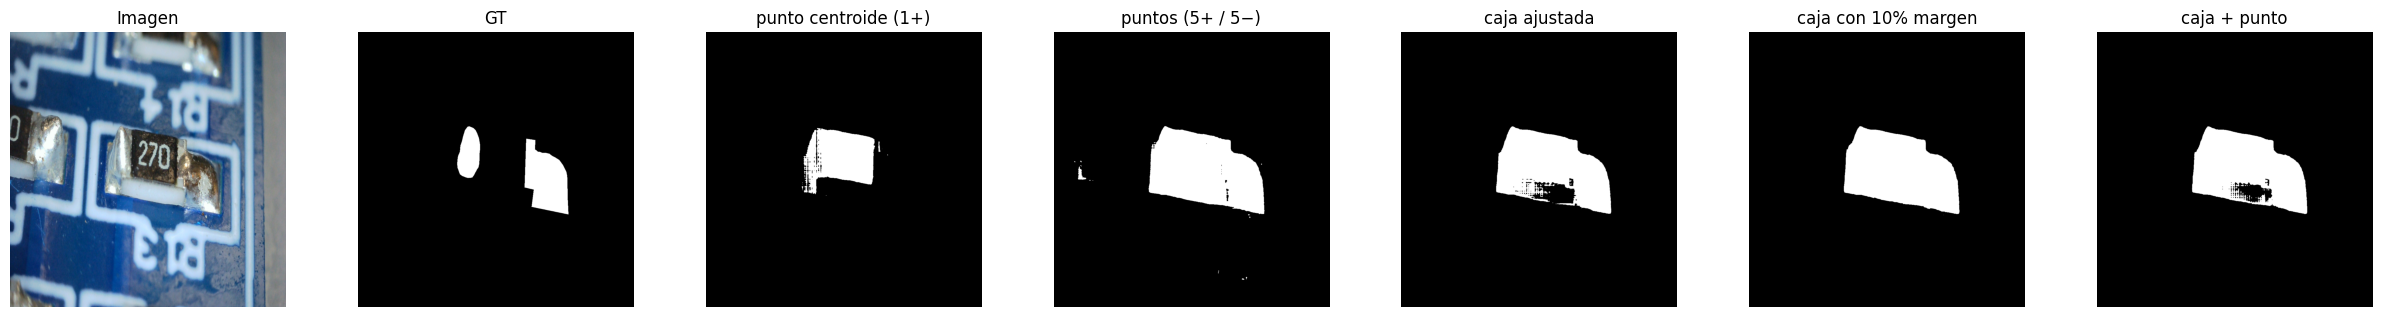

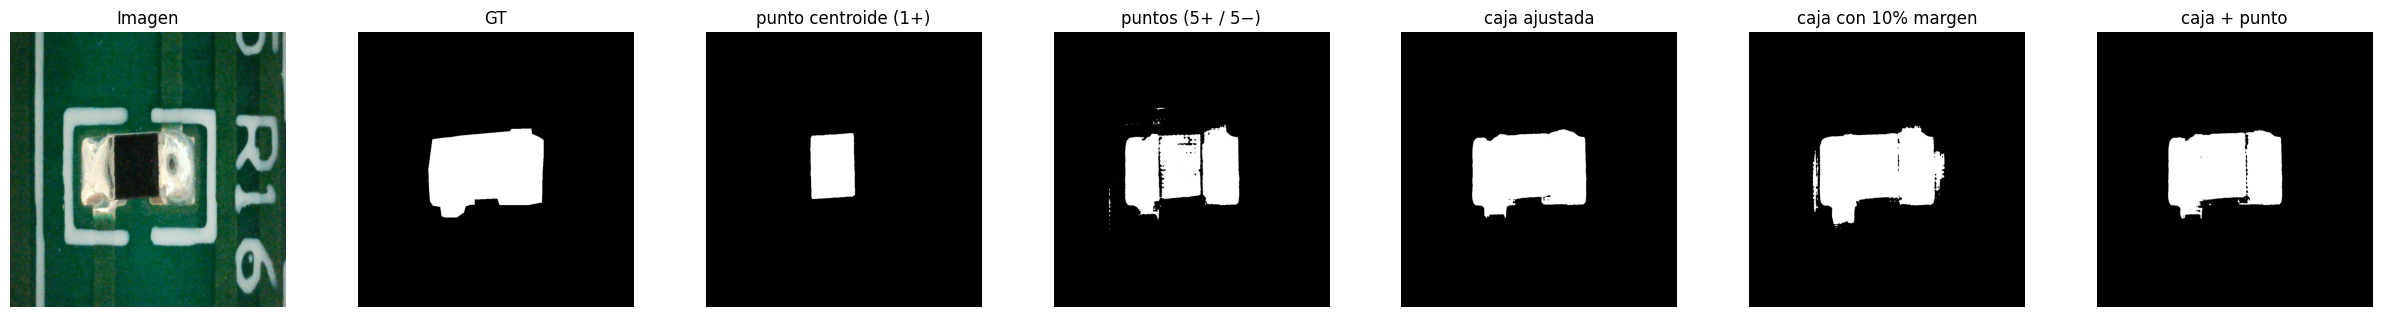

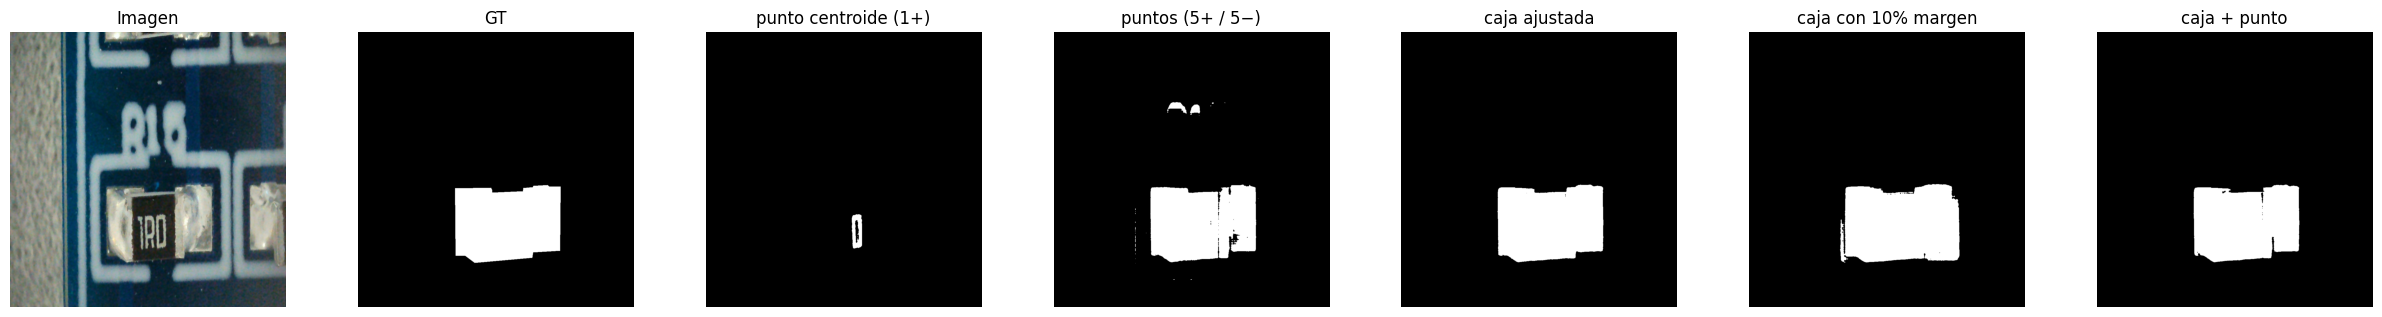

Resultados PRE:
               Prompt       IoU      Dice      Prec       Rec   N
0          box_tight  0.760174  0.837825  0.784659  0.962214  86
1     box_plus_point  0.751454  0.831155  0.788929  0.941189  86
2        box_loose10  0.712811  0.799108  0.731422  0.951579  86
3  points_posneg_5_5  0.683583  0.792237  0.755340  0.906203  86
4     point_centroid  0.192535  0.284315  0.690876  0.245490  86
🚀 Evaluando SAM (decoder fine-tuned)…


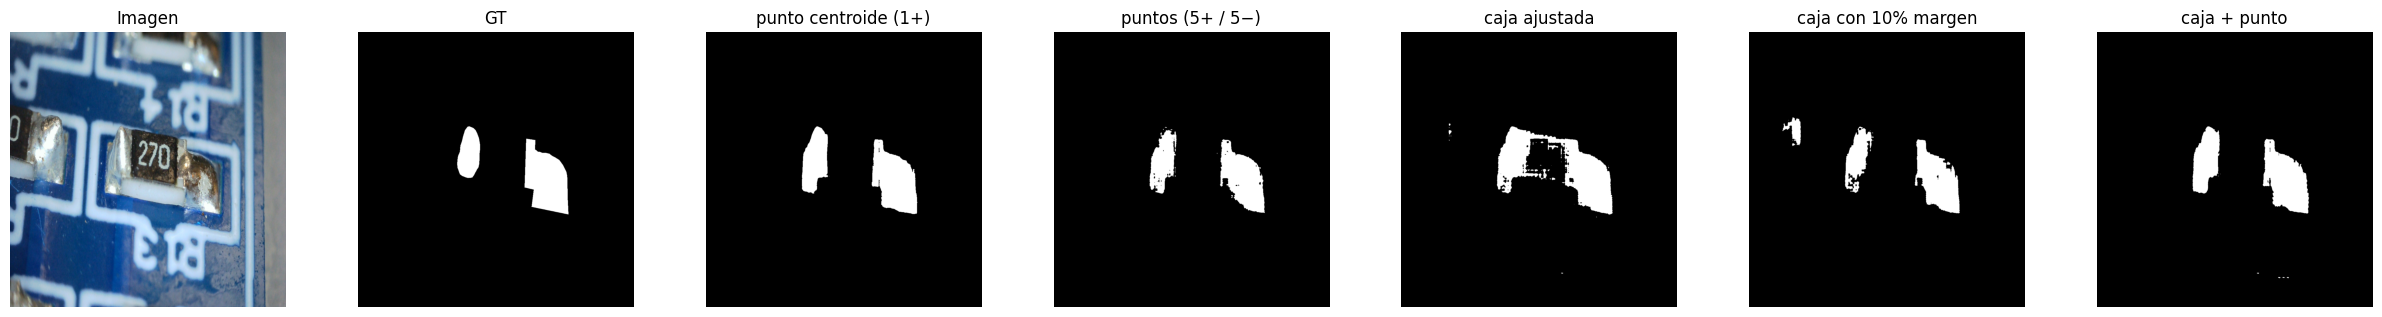

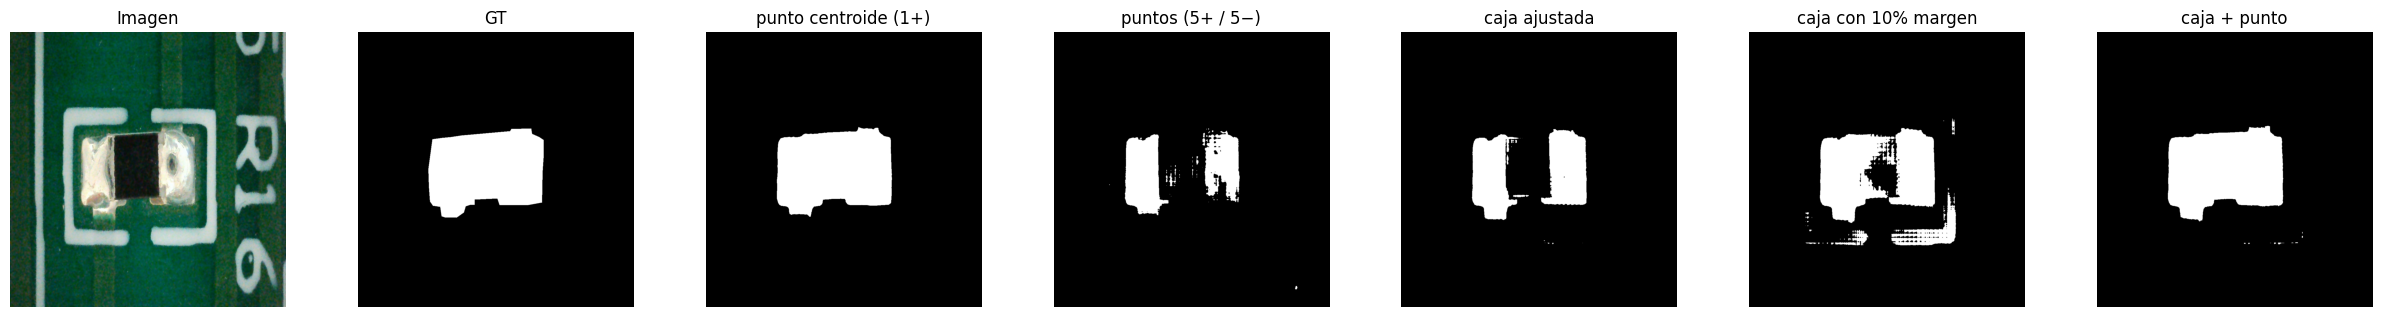

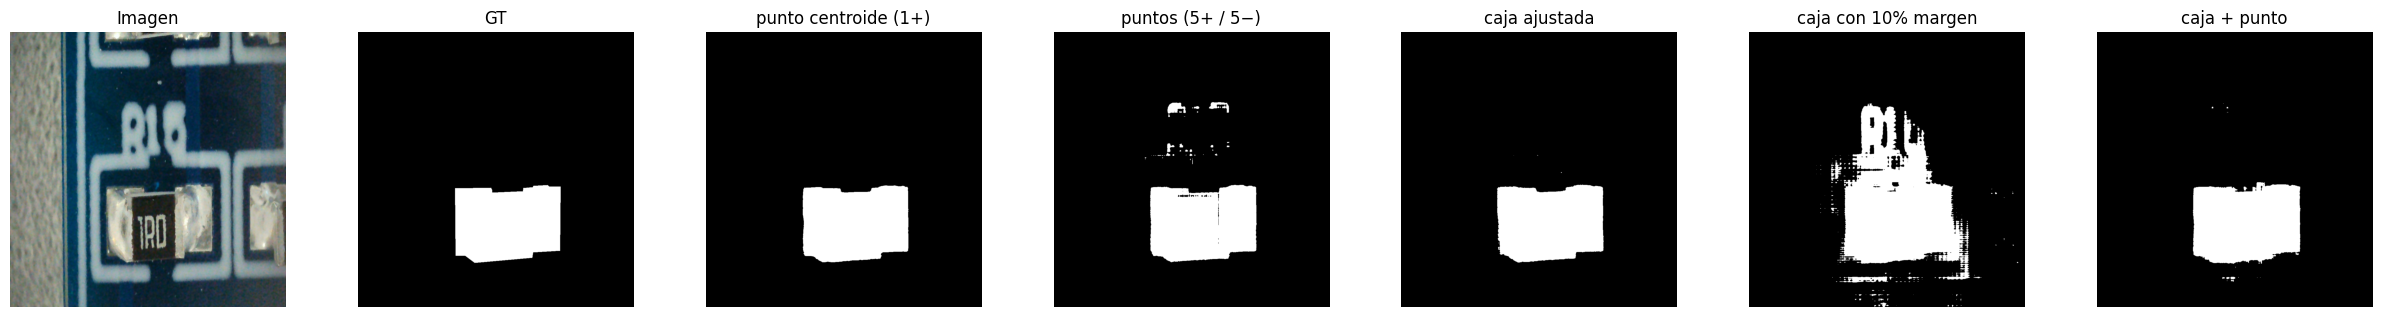

Resultados FT:
               Prompt       IoU      Dice      Prec       Rec   N
0     point_centroid  0.924744  0.959405  0.953171  0.967866  86
1     box_plus_point  0.867316  0.924636  0.902115  0.953893  86
2          box_tight  0.773388  0.859737  0.875382  0.875284  86
3  points_posneg_5_5  0.754707  0.851205  0.904417  0.827813  86
4        box_loose10  0.746976  0.844548  0.852422  0.871100  86

Comparativa PRE vs FT por prompt:
               Prompt   IoU_PRE    IoU_FT  Dice_PRE   Dice_FT  N_PRE  N_FT
0        box_loose10  0.712811  0.746976  0.799108  0.844548     86    86
1     box_plus_point  0.751454  0.867316  0.831155  0.924636     86    86
2          box_tight  0.760174  0.773388  0.837825  0.859737     86    86
3     point_centroid  0.192535  0.924744  0.284315  0.959405     86    86
4  points_posneg_5_5  0.683583  0.754707  0.792237  0.851205     86    86


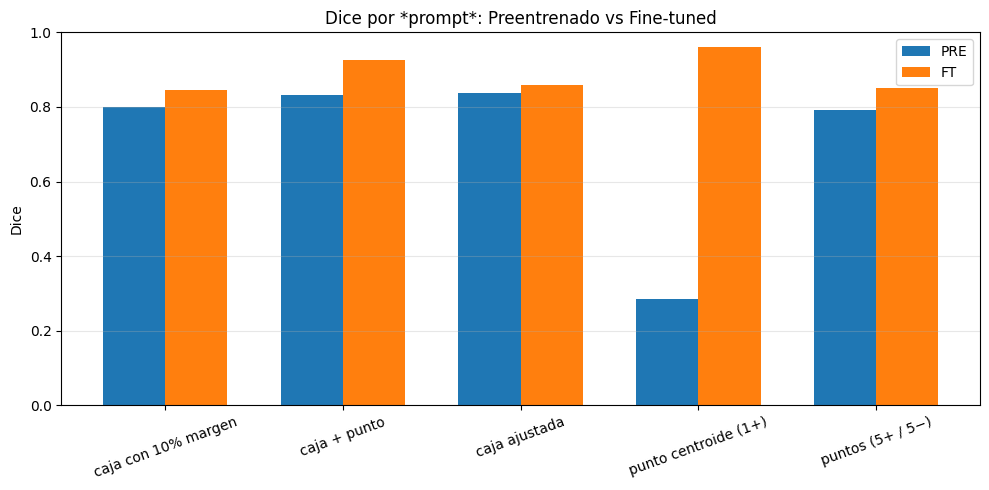

In [ ]:
# IMPORTS
import os, numpy as np, torch, matplotlib.pyplot as plt, pandas as pd
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry, SamPredictor

#MAPE0: nombres de prompts
PROMPT_LABELS_ES = {
    "point_centroid":     "punto centroide (1+)",
    "points_posneg_5_5":  "puntos (5+ / 5−)",
    "box_tight":          "caja ajustada",
    "box_loose10":        "caja con 10% margen",
    "box_plus_point":     "caja + punto",
}

# ==================== HELPERS BÁSICOS ====================
def maybe_denorm_imagenet(imgs: torch.Tensor, device="cuda"):
    """
    Auto-detecta si las imágenes están normalizadas a ImageNet por rango.
    Devuelve en [0,1].
    """
    mn, mx = float(imgs.min()), float(imgs.max())
    if mn < -0.05 or mx > 1.05:
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        return (imgs * std + mean).clamp(0,1)
    return imgs.clamp(0,1)

def compute_metrics(pred_bin: torch.Tensor, gt_bin: torch.Tensor):
    inter = (pred_bin * gt_bin).sum().item()
    union = (pred_bin + gt_bin).clamp(0,1).sum().item()
    ps, gs = pred_bin.sum().item(), gt_bin.sum().item()
    iou  = inter / (union + 1e-7)
    dice = 2 * inter / (ps + gs + 1e-7)
    prec = inter / (ps + 1e-7)
    rec  = inter / (gs + 1e-7)
    return iou, dice, prec, rec

def mask_bbox(gt_bin_np: np.ndarray, loose_factor: float = 0.0):
    """ bbox de la máscara GT: (x_min, y_min, x_max, y_max) con margen opcional """
    ys, xs = np.where(gt_bin_np > 0.5)
    if len(xs) == 0: return None
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    if loose_factor > 0:
        h, w = gt_bin_np.shape
        dx = int((x1 - x0 + 1) * loose_factor)
        dy = int((y1 - y0 + 1) * loose_factor)
        x0 = max(0, x0 - dx); y0 = max(0, y0 - dy)
        x1 = min(w-1, x1 + dx); y1 = min(h-1, y1 + dy)
    return np.array([[x0, y0, x1, y1]], dtype=np.float32)

def sample_points_posneg(gt_bin_np: np.ndarray, n_pos=5, n_neg=5, seed=123):
    rs = np.random.RandomState(seed)
    ys_pos, xs_pos = np.where(gt_bin_np > 0.5)
    ys_neg, xs_neg = np.where(gt_bin_np <= 0.5)
    if len(xs_pos) == 0: return None, None
    idx_pos = rs.choice(len(xs_pos), size=min(n_pos, len(xs_pos)), replace=False)
    pts_pos = np.stack([xs_pos[idx_pos], ys_pos[idx_pos]], axis=1)
    labels_pos = np.ones((pts_pos.shape[0],), dtype=np.int32)
    if len(xs_neg) > 0 and n_neg > 0:
        idx_neg = rs.choice(len(xs_neg), size=min(n_neg, len(xs_neg)), replace=False)
        pts_neg = np.stack([xs_neg[idx_neg], ys_neg[idx_neg]], axis=1)
        labels_neg = np.zeros((pts_neg.shape[0],), dtype=np.int32)
        pts = np.vstack([pts_pos, pts_neg]).astype(np.float32)
        labels = np.concatenate([labels_pos, labels_neg]).astype(np.int32)
    else:
        pts, labels = pts_pos.astype(np.float32), labels_pos
    return pts, labels

# =================== PROMPTS CONFIGS ===================
def make_prompts(gt_bin_t: torch.Tensor):
    """
    Recibe GT tensor (1,H,W). Devuelve dict {nombre: dict(point_coords, point_labels, box)}
    en coords de imagen original (pixeles). Usaremos SamPredictor para el resto.
    """
    gt_np = gt_bin_t[0].detach().cpu().numpy()
    prompts = {}

    # 1) Punto centroide (1 positivo)
    ys, xs = np.where(gt_np > 0.5)
    if len(xs) > 0:
        cy, cx = ys.mean().astype(np.float32), xs.mean().astype(np.float32)
        prompts["point_centroid"] = {
            "point_coords": np.array([[cx, cy]], dtype=np.float32),
            "point_labels": np.array([1], dtype=np.int32),
            "box": None,
        }

    # 2) Varios puntos +/−
    pts, labels = sample_points_posneg(gt_np, n_pos=5, n_neg=5, seed=123)
    if pts is not None:
        prompts["points_posneg_5_5"] = {
            "point_coords": pts.astype(np.float32),
            "point_labels": labels.astype(np.int32),
            "box": None,
        }

    # 3) Caja tight
    box_t = mask_bbox(gt_np, loose_factor=0.0)
    if box_t is not None:
        prompts["box_tight"] = {"point_coords": None, "point_labels": None, "box": box_t}

    # 4) Caja loose (10% margen)
    box_l = mask_bbox(gt_np, loose_factor=0.10)
    if box_l is not None:
        prompts["box_loose10"] = {"point_coords": None, "point_labels": None, "box": box_l}

    # 5) Caja + 1 punto
    if box_t is not None and "point_centroid" in prompts:
        prompts["box_plus_point"] = {
            "point_coords": prompts["point_centroid"]["point_coords"],
            "point_labels": prompts["point_centroid"]["point_labels"],
            "box": box_t,
        }
    return prompts

# =============== EVALUACIÓN CON PREDICTOR ===============
def eval_sam_with_prompts(sam_model, dataloader, device="cuda", thr=0.5,
                          visualizar=True, max_vis=3, seed=123):
    """
    Evalúa un modelo SAM (pre o fine-tuned) con varios prompts.
    Devuelve un DataFrame con métricas promedio por prompt.
    """
    torch.manual_seed(seed); np.random.seed(seed)
    sam_model.eval().to(device)
    predictor = SamPredictor(sam_model)

    acc = {}  # prompt -> {"IoU":[], "Dice":[], "Prec":[], "Rec":[]}
    shown = 0

    with torch.no_grad():
        for images, masks_gt in dataloader:
            images = images.to(device, non_blocking=True)   # (B,3,H,W)
            masks  = masks_gt.to(device, non_blocking=True) # (B,1,H,W)
            images_rgb01 = maybe_denorm_imagenet(images, device=device)

            B, _, H, W = images_rgb01.shape
            for b in range(B):
                gt = (masks[b] > 0.5).float()  # (1,H,W)
                if gt.sum() == 0: continue

                # preparar imagen para predictor (uint8 HWC RGB)
                img_np = (images_rgb01[b].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
                predictor.set_image(img_np)

                # prompts para esta muestra
                prompts = make_prompts(gt)

                preds_for_viz = {}  # prompt -> bin mask np
                for name, prm in prompts.items():
                    kwargs = {}
                    if prm["point_coords"] is not None:
                        kwargs["point_coords"] = prm["point_coords"]
                        kwargs["point_labels"] = prm["point_labels"]
                    if prm["box"] is not None:
                        kwargs["box"] = prm["box"]

                    masks_pred, scores, logits = predictor.predict(
                        multimask_output=False, **kwargs
                    )
                    pred = torch.from_numpy(masks_pred[0]).to(device).float().unsqueeze(0).unsqueeze(0) # (1,1,H,W)
                    pred_bin = (pred > thr).float()
                    iou, dice, prec, rec = compute_metrics(pred_bin, gt.unsqueeze(0))

                    if name not in acc:
                        acc[name] = {"IoU":[], "Dice":[], "Prec":[], "Rec":[]}
                    acc[name]["IoU"].append(iou)
                    acc[name]["Dice"].append(dice)
                    acc[name]["Prec"].append(prec)
                    acc[name]["Rec"].append(rec)

                    if visualizar and shown < max_vis:
                        preds_for_viz[name] = pred_bin[0,0].detach().cpu().numpy()

                # visualización (una figura por imagen con todas las predicciones)
                if visualizar and shown < max_vis and len(preds_for_viz) > 0:
                    cols = 2 + len(preds_for_viz)
                    fig, axes = plt.subplots(1, cols, figsize=(3.5*cols, 3.2))
                    axes = axes.flatten()
                    axes[0].imshow(img_np); axes[0].set_title("Imagen"); axes[0].axis("off")
                    axes[1].imshow(gt[0].detach().cpu(), cmap="gray"); axes[1].set_title("GT"); axes[1].axis("off")
                    for j,(name, m) in enumerate(preds_for_viz.items(), start=2):
                        axes[j].imshow(m, cmap="gray")
                        # —— título EN ESPAÑOL ——
                        axes[j].set_title(PROMPT_LABELS_ES.get(name, name))
                        axes[j].axis("off")
                    plt.tight_layout(); plt.show()
                    shown += 1

    # promedios por prompt (se devuelven con clave interna; renombraremos luego para gráfica)
    rows = []
    for name, d in acc.items():
        rows.append({
            "Prompt": name,
            "IoU":  float(np.mean(d["IoU"])) if d["IoU"] else 0.0,
            "Dice": float(np.mean(d["Dice"])) if d["Dice"] else 0.0,
            "Prec": float(np.mean(d["Prec"])) if d["Prec"] else 0.0,
            "Rec":  float(np.mean(d["Rec"])) if d["Rec"] else 0.0,
            "N":    len(d["IoU"])
        })
    df = pd.DataFrame(rows).sort_values("Dice", ascending=False).reset_index(drop=True)
    return df

# ================ CARGA Y COMPARATIVA =================
# Config
sam_type = "vit_b"
sam_ckpt_path = "/content/checkpoints/sam_vit_b.pth"
fine_tuned_decoder_path = "/content/drive/MyDrive/TFG/checkpoints/sam_decoder_best_dice.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# PREENTRENADO
sam_pre = sam_model_registry[sam_type](checkpoint=sam_ckpt_path).to(device)
print("🔎 Evaluando SAM preentrenado…")
df_pre = eval_sam_with_prompts(sam_pre, val_loader, device=device, thr=0.5, visualizar=True, max_vis=3)
print("Resultados PRE:\n", df_pre)

# FINETUNED (carga solo decoder)
del sam_pre; torch.cuda.empty_cache()
sam_ft = sam_model_registry[sam_type](checkpoint=sam_ckpt_path).to(device)
sam_ft.mask_decoder.load_state_dict(torch.load(fine_tuned_decoder_path, map_location=device))
print("🚀 Evaluando SAM (decoder fine-tuned)…")
df_ft = eval_sam_with_prompts(sam_ft, val_loader, device=device, thr=0.5, visualizar=True, max_vis=3)
print("Resultados FT:\n", df_ft)

# ================ GRÁFICA COMPARATIVA =================
# Unimos por prompt (clave interna)
df_merge = pd.merge(df_pre, df_ft, on="Prompt", how="outer", suffixes=("_PRE","_FT"))
print("\nComparativa PRE vs FT por prompt:\n", df_merge[["Prompt","IoU_PRE","IoU_FT","Dice_PRE","Dice_FT","N_PRE","N_FT"]])

# —— Etiquetas en ESPAÑOL para el eje X ——
labels_es = [PROMPT_LABELS_ES.get(k, k) for k in df_merge["Prompt"]]

# Barras por Dice con nombres en español
plt.figure(figsize=(10,5))
x = np.arange(len(labels_es))
w = 0.35
plt.bar(x - w/2, df_merge["Dice_PRE"], width=w, label="PRE")
plt.bar(x + w/2, df_merge["Dice_FT"],  width=w, label="FT")
plt.xticks(x, labels_es, rotation=20)
plt.ylim(0,1)
plt.ylabel("Dice")
plt.title("Dice por *prompt*: Preentrenado vs Fine-tuned")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# === (Re)carga de modelos para el perfilado ===
import torch
from segment_anything import sam_model_registry

# Ajusta estas rutas si en tu notebook tienen otros valores
sam_type = "vit_b"
sam_ckpt_path = "/content/checkpoints/sam_vit_b.pth"
fine_tuned_decoder_path = "/content/drive/MyDrive/TFG/checkpoints/sam_decoder_best_dice.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Modelo preentrenado
sam_pre = sam_model_registry[sam_type](checkpoint=sam_ckpt_path).to(device)
sam_pre.eval()

# Modelo fine-tuned: cargamos el decoder ajustado
sam_ft = sam_model_registry[sam_type](checkpoint=sam_ckpt_path).to(device)
ckpt = torch.load(fine_tuned_decoder_path, map_location=device)
sam_ft.mask_decoder.load_state_dict(ckpt)
sam_ft.eval()

# limpia caché de GPU si vienes de entrenar en la misma sesión
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Comprobación rápida
assert 'val_loader' in globals(), "val_loader no está definido. Ejecuta la celda donde lo creaste."


In [ ]:
# ================= PERFILADO DE LATENCIA Y VRAM =================
import time, torch, numpy as np, pandas as pd
from segment_anything import SamPredictor

def profile_predictor(predictor, img_np, **kwargs):
    """Perfila una predicción: tiempo (s) y pico de VRAM (MB)."""
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        try:
            torch.cuda.reset_peak_memory_stats()
        except Exception:
            pass
    t0 = time.time()

    predictor.set_image(img_np)  # RGB uint8 HWC
    masks_pred, _, _ = predictor.predict(multimask_output=False, **kwargs)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
        vram = torch.cuda.max_memory_allocated() / 1e6
    else:
        vram = 0.0
    dt = time.time() - t0
    return masks_pred, dt, vram

def _kwargs_from_prompt(prm: dict):
    """Convierte un prompt de make_prompts() en kwargs para SamPredictor."""
    kwargs = {}
    if prm.get("point_coords") is not None:
        kwargs["point_coords"] = prm["point_coords"]
        kwargs["point_labels"] = prm["point_labels"]
    if prm.get("box") is not None:
        kwargs["box"] = prm["box"]
    return kwargs

def profile_model_over_loader(
    sam_model,
    dataloader,
    device="cuda",
    prompts_to_test=("box_plus_point", "point_centroid"),
    max_imgs=50,
    seed=0,
):

    torch.manual_seed(seed); np.random.seed(seed)
    sam_model.eval().to(device)
    predictor = SamPredictor(sam_model)

    registros = []
    vistos = 0

    with torch.no_grad():
        for images, masks_gt in dataloader:
            images = images.to(device, non_blocking=True)
            masks_gt = masks_gt.to(device, non_blocking=True)
            images_rgb01 = maybe_denorm_imagenet(images, device=device)

            B, _, H, W = images_rgb01.shape
            for b in range(B):
                gt = (masks_gt[b] > 0.5).float()
                if gt.sum() == 0:
                    continue

                # Imagen RGB uint8 HWC
                img_np = (images_rgb01[b].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)

                # Prompts disponibles para esta máscara
                prm_all = make_prompts(gt)

                # Perfilado por cada prompt solicitado (si existe)
                for pname in prompts_to_test:
                    if pname not in prm_all:
                        continue
                    kwargs = _kwargs_from_prompt(prm_all[pname])
                    _, dt, vram = profile_predictor(predictor, img_np, **kwargs)
                    registros.append({"prompt": pname, "dt_s": dt, "vram_MB": vram})

                vistos += 1
                if vistos >= max_imgs:
                    break
            if vistos >= max_imgs:
                break

    df = pd.DataFrame(registros)
    if df.empty:
        return df, pd.DataFrame(columns=["prompt","mean_dt_ms","std_dt_ms","mean_vram_MB","N"])

    # Resumen por prompt (tiempo en ms)
    summary = (
        df.groupby("prompt")
          .agg(mean_dt_ms=("dt_s", lambda x: 1000*np.mean(x)),
               std_dt_ms =("dt_s", lambda x: 1000*np.std(x)),
               mean_vram_MB=("vram_MB", "mean"),
               N=("dt_s","size"))
          .reset_index()
          .sort_values("mean_dt_ms")
    )
    return df, summary


# 1) Perfilado PREENTRENADO
df_rt_pre, sum_rt_pre = profile_model_over_loader(
    sam_pre, val_loader, device=device,
    prompts_to_test=("box_plus_point", "point_centroid"),
    max_imgs=60
)
print("⏱️ PRE — Latencia/VRAM por prompt:\n", sum_rt_pre)

# 2) Perfilado FINE-TUNED (mismo subconjunto y límite)
df_rt_ft, sum_rt_ft = profile_model_over_loader(
    sam_ft, val_loader, device=device,
    prompts_to_test=("box_plus_point", "point_centroid"),
    max_imgs=60
)
print("⏱️ FT — Latencia/VRAM por prompt:\n", sum_rt_ft)

# 3) Tabla comparativa PRE vs FT
rt_comp = sum_rt_pre.merge(sum_rt_ft, on="prompt", suffixes=("_PRE","_FT"))
rt_comp["speedup_x"] = rt_comp["mean_dt_ms_PRE"] / (rt_comp["mean_dt_ms_FT"] + 1e-9)
rt_comp = rt_comp[["prompt",
                   "mean_dt_ms_PRE","mean_dt_ms_FT","speedup_x",
                   "mean_vram_MB_PRE","mean_vram_MB_FT",
                   "N_PRE","N_FT"]]
print("\n📊 Comparativa latencia/VRAM PRE vs FT:\n", rt_comp)


⏱️ PRE — Latencia/VRAM por prompt:
            prompt  mean_dt_ms  std_dt_ms  mean_vram_MB   N
0  box_plus_point  462.699064  21.302549   3828.676062  60
1  point_centroid  482.565812  29.052602   3828.350566  60
⏱️ FT — Latencia/VRAM por prompt:
            prompt  mean_dt_ms  std_dt_ms  mean_vram_MB   N
0  box_plus_point  456.052574  17.905829   3828.676062  60
1  point_centroid  471.566315  20.305838   3828.350566  60

📊 Comparativa latencia/VRAM PRE vs FT:
            prompt  mean_dt_ms_PRE  mean_dt_ms_FT  speedup_x  mean_vram_MB_PRE  \
0  box_plus_point      462.699064     456.052574   1.014574       3828.676062   
1  point_centroid      482.565812     471.566315   1.023325       3828.350566   

   mean_vram_MB_FT  N_PRE  N_FT  
0      3828.676062     60    60  
1      3828.350566     60    60  
